# A Perfect Reconstruction Filter Bank (PRFB)
Using MST filters.

```
             La      L       Lb           Lc
   +--> K_0 ---> d2 ---> u2 ---> 1/2*K_0 ---+
   |                                        |
x  |                                        | _x
---+                                        +--->
   |                                        |
   |                                        |
   +--> K_1 ---> d2 ---> u2 ---> 1/2*K_1 ---+
             Ha      H       Hb           Hc
```

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sounddevice as sd

In [2]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

In [3]:
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred


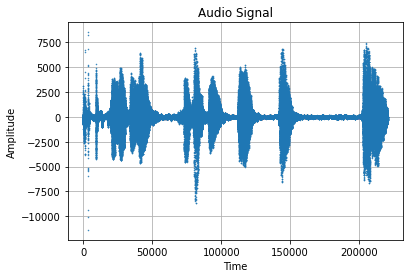

In [4]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Time", "Amplitude", "Audio Signal")

### Low-frequency subband (analysis)
We convolve $x$ with $K_0=[1, 1]$.

In [5]:
La = np.convolve(x[:, 0], [1.0, 1.0])

In [6]:
for i in range(20):
    print(float(x[i][0]), end= ' ')
print()
for i in range(20):
    print(La[i], end= ' ')

138.0 162.0 211.0 252.0 272.0 293.0 290.0 251.0 220.0 218.0 199.0 192.0 165.0 118.0 105.0 86.0 95.0 106.0 107.0 148.0 
138.0 300.0 373.0 463.0 524.0 565.0 583.0 541.0 471.0 438.0 417.0 391.0 357.0 283.0 223.0 191.0 181.0 201.0 213.0 255.0 

ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred


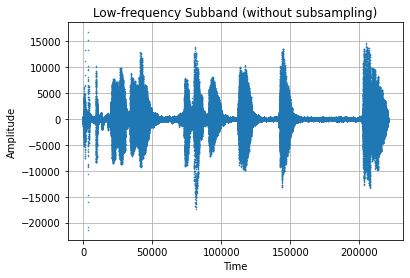

In [7]:
sd.play((La//2).astype(np.int16))
plot(np.linspace(0, len(La)-1, len(La)), La, "Time", "Amplitude", "Low-frequency Subband (without subsampling)")

Notice that the gain of this filter is 2.

### High-frequency subband (analysis)
We convolve $x$ with $K_1=[1, -1]$.

In [8]:
Ha = np.convolve(x[:, 0], [1.0, -1.0])

In [9]:
for i in range(20):
    print(float(x[i][0]), end= ' ')
print()
for i in range(20):
    print(Ha[i], end= ' ')

138.0 162.0 211.0 252.0 272.0 293.0 290.0 251.0 220.0 218.0 199.0 192.0 165.0 118.0 105.0 86.0 95.0 106.0 107.0 148.0 
138.0 24.0 49.0 41.0 20.0 21.0 -3.0 -39.0 -31.0 -2.0 -19.0 -7.0 -27.0 -47.0 -13.0 -19.0 9.0 11.0 1.0 41.0 

ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred


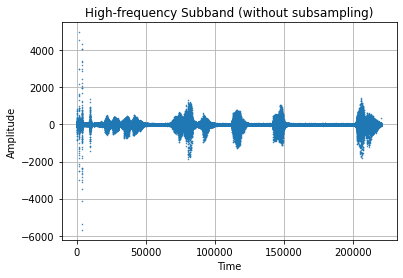

In [10]:
sd.play((Ha//2).astype(np.int16))
plot(np.linspace(0, len(Ha)-1, len(Ha)), Ha, "Time", "Amplitude", "High-frequency Subband (without subsampling)")

Now it's more difficult to see that the signal gain of $K_1$ is 2, but this is the real gain.

### Subsampling (decimation)
Set to zero half of the transform coefficients.

In [11]:
Lb = La.copy()
Hb = Ha.copy()
Lb[1::2] = 0
Hb[1::2] = 0

### Low-frequency subband (synthesis)

In [12]:
Lc = np.convolve(Lb, [0.5, 0.5])

In [13]:
for i in range(20):
    print(float(Lb[i]), end= ' ')
print()
for i in range(20):
    print(Lc[i], end= ' ')

138.0 0.0 373.0 0.0 524.0 0.0 583.0 0.0 471.0 0.0 417.0 0.0 357.0 0.0 223.0 0.0 181.0 0.0 213.0 0.0 
69.0 69.0 186.5 186.5 262.0 262.0 291.5 291.5 235.5 235.5 208.5 208.5 178.5 178.5 111.5 111.5 90.5 90.5 106.5 106.5 

### High frequency subband (synthesis)

In [14]:
Hc = np.convolve(Hb, [0.5, -0.5])

In [15]:
for i in range(20):
    print(float(Hb[i]), end= ' ')
print()
for i in range(20):
    print(Hc[i], end= ' ')

138.0 0.0 49.0 0.0 20.0 0.0 -3.0 0.0 -31.0 0.0 -19.0 0.0 -27.0 0.0 -13.0 0.0 9.0 0.0 1.0 0.0 
69.0 -69.0 24.5 -24.5 10.0 -10.0 -1.5 1.5 -15.5 15.5 -9.5 9.5 -13.5 13.5 -6.5 6.5 4.5 -4.5 0.5 -0.5 

### Add the subbans

In [16]:
_x = Lc + Hc

In [17]:
_x_ = np.empty_like(_x)
_x_[0::2] = _x[0::2]
_x_[1::2] = np.roll(_x[1::2],-1) # The even samples are delayed

In [18]:
_x_ = _x_.astype(np.int16).reshape((len(_x),1))

ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred


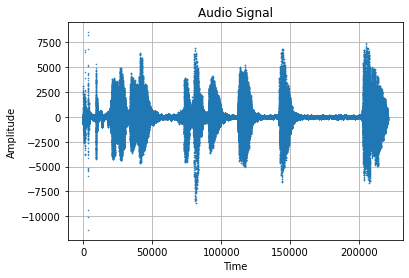

In [19]:
sd.play(_x_)
plot(np.linspace(0, len(_x_)-1, len(_x_)), _x_, "Time", "Amplitude", "Audio Signal")

### Perfect reconstruction test

In [20]:
(x == _x_[:-2]).all()

True

In [21]:
for i in range(20):
    print(x[i][0], end= ' ')

138 162 211 252 272 293 290 251 220 218 199 192 165 118 105 86 95 106 107 148 

In [22]:
for i in range(20):
    print(_x_[i][0], end= ' ')

138 162 211 252 272 293 290 251 220 218 199 192 165 118 105 86 95 106 107 148 